# Documentación del Proyecto: Modelo de Predicción de Zonas de Pase

## Descripción del Proyecto
Este proyecto se enfoca en desarrollar un modelo de red neuronal para predecir la zona de pase en el campo de juego basado en diversas características de jugadas de fútbol americano. Utilizamos un conjunto de datos procesado para entrenar, validar y hacer predicciones, y abordamos problemas comunes como el balanceo de clases y la estandarización de características.

## Pasos Principales

### 1. Cargar y Preprocesar Datos
   - **Carga del Dataset:** Se cargó el conjunto de datos desde un archivo `.csv` y se inspeccionaron las primeras filas para verificar la estructura y los valores.
   - **Selección de Características:** Se eligieron 44 columnas relevantes (`feature_columns`) que el modelo de predicción espera recibir.
   - **Estandarización:** Se aplicó `StandardScaler` para estandarizar los datos y asegurar que todas las características tengan una escala similar, optimizando el rendimiento de la red neuronal.

### 2. Definición del Modelo de Red Neuronal
   - **Modelo Pre-entrenado:** Se cargó un modelo de red neuronal pre-entrenado usando Keras (`passing_zone_predictor_model.h5`).
   - **Estructura del Modelo:** La red tiene una capa de entrada con 44 neuronas (una por cada característica), capas ocultas con normalización por lotes (`BatchNormalization`) y capas de `Dropout` para reducir el sobreajuste.
   - **Compilación del Modelo:** Se usó la función de pérdida `sparse_categorical_crossentropy` y el optimizador `Adam` con una tasa de aprendizaje ajustada para un rendimiento óptimo.

### 3. Mapeo de Valores Categóricos
   A continuación se muestran ejemplos de la codificación de valores categóricos utilizada para las características relevantes:
   
   #### Ejemplos de Codificación Categórica
   - **Dirección de la Jugada (PLAY DIR)**
     - `0`: Izquierda
     - `1`: Derecha
     - `2`: Centro
   - **Zonas de Pase (PASS ZONE)**
     - `0`: Corta Izquierda
     - `1`: Corta Centro
     - `2`: Corta Derecha
     - `3`: Profunda Izquierda
     - `4`: Profunda Centro
     - `5`: Profunda Derecha
   - **Cobertura (COVERAGE)**
     - `0`: Cobertura de Zona
     - `1`: Cobertura de Hombre a Hombre
     - `2`: Cobertura Mixta
     - `3`: Blitz (presión rápida)
   - **Campos ODK ofensiva/defensiva (ODK ofensiva/ defensiva/ jugadas extras_K, O, S)**
     - `0`: No activa
     - `1`: Activa
   - **Formaciones Ofensivas (OFF FORM_ARROW, OFF FORM_BUNCH, etc.)**
     - `0`: La formación no está en uso.
     - `1`: La formación está en uso.
   - **Tipo de Jugada (PLAY TYPE)**
     - `PLAY TYPE_Pass`: `1` si la jugada es de pase, `0` de lo contrario.
     - `PLAY TYPE_Run`: `1` si la jugada es de carrera, `0` de lo contrario.
     - `PLAY TYPE_Extra Pt.`: `1` si es una jugada de punto extra.
   - **Indicadores del Rival (RIVAL_CAN, RIVAL_FRA, etc.)**
     - `0`: No es el equipo rival.
     - `1`: Es el equipo rival.
   
### 4. Entrenamiento y Evaluación del Modelo
   - **División de Datos:** Se utilizó una división de entrenamiento y prueba para evaluar el rendimiento del modelo.
   - **Balanceo de Clases:** Para abordar el desequilibrio de clases, se calculó el `class_weight` para dar más peso a las clases menos representadas.
   - **Entrenamiento con Callbacks:** Se usaron `EarlyStopping` y `ReduceLROnPlateau` para ajustar el entrenamiento, deteniendo el proceso si el rendimiento en el conjunto de validación no mejoraba.
   - **Evaluación:** Se imprimieron métricas de precisión y pérdida en el conjunto de prueba para validar el rendimiento del modelo.

### 5. Predicción de Zona de Pase para una Nueva Jugada
   - **Simulación de Datos:** Se creó un nuevo conjunto de datos (`new_play_data`) con valores hipotéticos, alineados con las 44 características que el modelo espera.
   - **Preprocesamiento:** Los datos fueron estandarizados antes de ser introducidos en el modelo.
   - **Predicción:** El modelo devuelve una predicción de la zona de pase y una distribución de probabilidad para cada zona.

### 6. Interpretación de Resultados
   - **Zona Predicha:** La zona de pase más probable según el modelo.
   - **Distribución de Probabilidad:** Muestra la probabilidad para cada zona de pase posible, permitiendo una comprensión más completa de las predicciones del modelo.


In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np

In [7]:
# Step 2: Load the dataset
file_path = r"C:\Users\lalde\Downloads\playdata.csv"  # Raw string method
data = pd.read_csv(file_path)

In [9]:
# Step 3: Initial inspection of missing values
print("Missing Data Overview:")
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(data)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
print(missing_info[missing_info['Missing Values'] > 0])  # Show only columns with missing data

Missing Data Overview:
                       Missing Values  Percentage
MOTION                            599   99.667221
MOTION DIR                        599   99.667221
INTERCEPTED BY_Name               593   98.668885
INTERCEPTED BY_Jersey             593   98.668885
RUSHER_Name                       581   96.672213
RUSHER_Jersey                     581   96.672213
KEY PLAYER_Name                   576   95.840266
KEY PLAYER_Jersey                 576   95.840266
TACKLER1_Name                     446   74.209651
TACKLER1_Jersey                   446   74.209651
RECEIVER_Name                     427   71.048253
RECEIVER_Jersey                   427   71.048253
OFF PLAY                          370   61.564060
PASSER_Jersey                     338   56.239601
PASSER_Name                       338   56.239601
BLZ_Jersey                        300   49.916805
BLZ_Name                          300   49.916805
COVERAGE                          294   48.918469
PI                         

In [17]:
# Impute DISTANCIA and YARD LN with median values
data['DISTANCIA'] = data['DISTANCIA'].fillna(data['DISTANCIA'].median())
data['YARD LN'] = data['YARD LN'].fillna(data['YARD LN'].median())

In [19]:
# Impute OFF FORM with the mode (most common formation)
data['OFF FORM'] = data['OFF FORM'].fillna(data['OFF FORM'].mode()[0])

In [21]:
# Drop columns with excessive missing data (>50%)
columns_to_drop = missing_info[missing_info['Percentage'] > 50].index
data.drop(columns=columns_to_drop, inplace=True)
print(f"Dropped columns with >50% missing data: {list(columns_to_drop)}")


Dropped columns with >50% missing data: ['MOTION', 'MOTION DIR', 'INTERCEPTED BY_Name', 'INTERCEPTED BY_Jersey', 'RUSHER_Name', 'RUSHER_Jersey', 'KEY PLAYER_Name', 'KEY PLAYER_Jersey', 'TACKLER1_Name', 'TACKLER1_Jersey', 'RECEIVER_Name', 'RECEIVER_Jersey', 'OFF PLAY', 'PASSER_Jersey', 'PASSER_Name']


In [23]:
# Step 4: Categorical Encoding
# Encode categorical variables using pd.get_dummies for simplicity
categorical_cols = ['RIVAL', 'ODK ofensiva/ defensiva/ jugadas extras', 'OFF FORM', 'OFF STR', 'PLAY TYPE']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [25]:
# Step 5: Feature Engineering
# Play Context: Extract quarter, down, and distance-related features
# Example assuming play numbers and series opportunities represent the down and quarter context.
# Further domain knowledge is needed for exact feature creation.
data['quarter'] = np.select(
    [data['PLAY #'] <= 15, data['PLAY #'] <= 30, data['PLAY #'] <= 45, data['PLAY #'] <= 60],
    [1, 2, 3, 4], default=4
)
data['down'] = data['DN oportunidades'].fillna(1)  # Fill any missing down values with 1 (first down)

In [27]:
# Field Position: Define field zones
def field_zone(yard_line):
    if yard_line <= 20:
        return 'Red Zone'
    elif yard_line <= 50:
        return 'Midfield'
    else:
        return 'Own Side'
data['field_zone'] = data['YARD LN'].apply(field_zone)
data = pd.get_dummies(data, columns=['field_zone'], drop_first=True)

In [29]:
# Play Result Categories: Define play outcome categories
def categorize_result(result):
    if 'TOUCHDOWN' in result.upper():
        return 'Touchdown'
    elif 'INTERCEPTION' in result.upper() or 'TURNOVER' in result.upper():
        return 'Turnover'
    elif 'LOSS' in result.upper() or 'NO GAIN' in result.upper():
        return 'No Gain'
    else:
        return 'Positive Gain'

data['play_result_category'] = data['RESULT'].fillna('Unknown').apply(categorize_result)
data = pd.get_dummies(data, columns=['play_result_category'], drop_first=True)

In [31]:
# Step 6: Final Check and Save Cleaned Data
print("\nData after preprocessing and feature engineering:")
print(data.head())
data.to_csv('playdata_processed.csv', index=False)
print("Data processed and saved as 'playdata_processed.csv'")


Data after preprocessing and feature engineering:
   PLAY #  HF 1ª o 2ª parte   SERIES oportunidades  DN oportunidades  \
0       1                  1                     1               1.0   
1       2                  1                     1               2.0   
2       3                  1                     1               3.0   
3       4                  1                     1               1.0   
4       5                  1                     1               2.0   

   DISTANCIA  YARD LN    RESULT   PI   PC  GN/LS  ... OFF STR_R  \
0       20.0     -5.0  Complete  1.0  1.0    8.0  ...     False   
1       12.0    -13.0  Complete  1.0  1.0    8.0  ...     False   
2        4.0    -21.0    1st DN  1.0  1.0   10.0  ...     False   
3       10.0     19.0  Complete  1.0  1.0    7.0  ...     False   
4       12.0     12.0  Complete  1.0  1.0    4.0  ...     False   

   PLAY TYPE_2 Pt. Defend PLAY TYPE_Extra Pt.  PLAY TYPE_Extra Pt. Block  \
0                   False            

In [33]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# Load the processed dataset
data = pd.read_csv('playdata_processed.csv')

In [39]:
# Step 2: Correlation Analysis
# Select only numeric columns for correlation analysis
numeric_cols = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

In [41]:
# Focus on correlations with 'YARD LN', 'DISTANCIA', and play outcomes
outcome_columns = [col for col in numeric_cols.columns if 'play_result_category_' in col]
correlation_focus = correlation_matrix[['YARD LN', 'DISTANCIA'] + outcome_columns]

In [43]:
# Display correlation matrix for key features
print("\nCorrelation matrix for YARD LN, DISTANCIA, and play outcomes:")
print(correlation_focus)


Correlation matrix for YARD LN, DISTANCIA, and play outcomes:
                       YARD LN  DISTANCIA
PLAY #                0.043517   0.039723
HF 1ª o 2ª parte     -0.011279  -0.000283
SERIES oportunidades  0.013329   0.062215
DN oportunidades     -0.318039  -0.243715
DISTANCIA             0.335511   1.000000
YARD LN               1.000000   0.335511
PI                         NaN        NaN
PC                   -0.081136   0.062818
GN/LS                -0.199085   0.085393
PASS ZONE             0.047728  -0.049987
BLZ_Jersey            0.058178   0.016619
quarter               0.021517   0.014468
down                 -0.318039  -0.243715


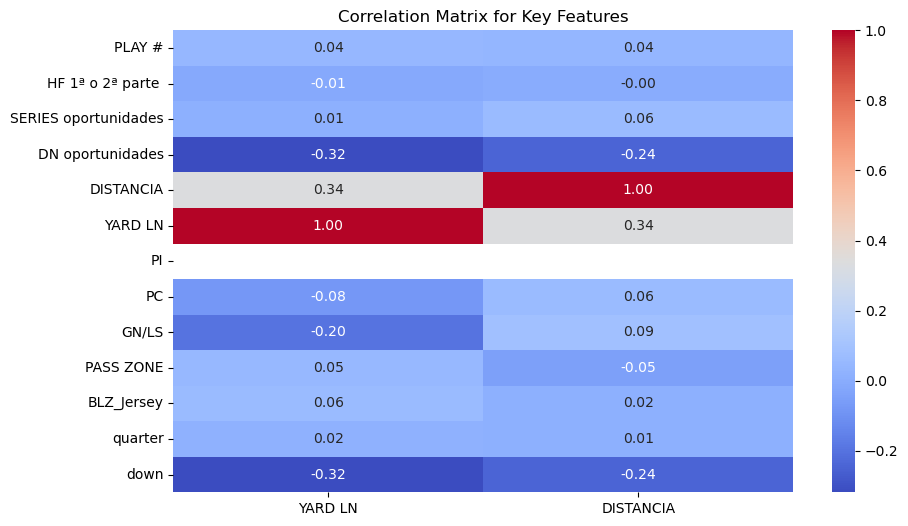

In [45]:
# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_focus, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Key Features")
plt.show()

### MODEL SELECTION ###

In [60]:
# Data handling
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# For neural network and random state
import numpy as np
np.random.seed(42)

In [62]:
# Load the processed data
data = pd.read_csv('playdata_processed.csv')

# Define the target and feature columns
target_column = 'PLAY TYPE_Pass'  # Example: Modify to the actual play type column or category
X = data.drop(columns=[target_column])  # Features
y = data[target_column]  # Target

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Random Forest ####

In [67]:
# Check for non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['RESULT', 'PLAY DIR', 'COVERAGE', 'BLZ_Name'], dtype='object')


In [69]:
# One-hot encode non-numeric columns
X_train = pd.get_dummies(X_train, columns=non_numeric_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=non_numeric_cols, drop_first=True)

# Align columns in X_train and X_test to ensure they match after encoding
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [71]:
# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
rf_preds = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Performance:")
print(classification_report(y_test, rf_preds))
print("Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Classifier Performance:
              precision    recall  f1-score   support

       False       1.00      0.96      0.98        23
        True       0.99      1.00      0.99        98

    accuracy                           0.99       121
   macro avg       0.99      0.98      0.99       121
weighted avg       0.99      0.99      0.99       121

Accuracy: 0.9917355371900827


# Objective of the Model

### 1. Classification Task
This model is a **binary classifier**, meaning it’s trained to categorize plays into one of two classes. For example:
- **True**: Indicates a *Pass* play is the best choice.
- **False**: Indicates a *Run* play is the best choice.

### 2. Play Prediction
Given certain situational features, the model predicts whether a particular play type (e.g., a *Pass*) is likely to be a good choice in a given situation.
- By analyzing features like **YARD LN**, **DISTANCIA**, **OFF FORM**, and other situational data, the model determines the most suitable play type.

In [74]:
# Data handling and model evaluation
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Feature selection
from sklearn.feature_selection import RFE

# Model
from sklearn.ensemble import RandomForestClassifier

In [76]:
# Load the processed dataset
data = pd.read_csv('playdata_processed.csv')

# Define the target variable and drop non-relevant columns
target_column = 'PLAY TYPE_Pass'  # Replace with actual target column name
non_relevant_cols = ['JERSEY_NUMBER', 'PLAYER_NAME', 'TACKLER_NAME']  # Adjust based on actual data
X = data.drop(columns=[target_column] + non_relevant_cols, errors='ignore')  # Features
y = data[target_column]  # Target

In [80]:
# One-hot encode non-numeric columns
X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

In [82]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Apply RFE to select the top features
rfe = RFE(estimator=rf_model, n_features_to_select=10)  # Adjust the number of features as needed
X_rfe = rfe.fit_transform(X, y)

# Check selected features
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['DN oportunidades', 'GN/LS',
       'ODK ofensiva/ defensiva/ jugadas extras_K',
       'ODK ofensiva/ defensiva/ jugadas extras_S', 'PLAY TYPE_Extra Pt.',
       'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Run', 'down', 'RESULT_Good',
       'RESULT_Rush'],
      dtype='object')


In [84]:
# Split data into training, validation, and test sets (60-20-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_rfe, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [86]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
print("Best parameters found:", best_params)
best_rf_model = grid_search.best_estimator_

Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


### MODEL EVALUATION ###

In [89]:
# Evaluate on validation set
val_preds = best_rf_model.predict(X_val)
print("Validation Set Performance:")
print("Accuracy:", accuracy_score(y_val, val_preds))
print("Precision:", precision_score(y_val, val_preds))
print("Recall:", recall_score(y_val, val_preds))
print("F1 Score:", f1_score(y_val, val_preds))

# Final evaluation on test set
test_preds = best_rf_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, test_preds))
print("Accuracy:", accuracy_score(y_test, test_preds))

Validation Set Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Test Set Performance:
              precision    recall  f1-score   support

       False       1.00      0.95      0.97        20
        True       0.99      1.00      1.00       101

    accuracy                           0.99       121
   macro avg       1.00      0.97      0.98       121
weighted avg       0.99      0.99      0.99       121

Accuracy: 0.9917355371900827


# Resumen del Rendimiento del Modelo y Conclusiones

## Descripción del Modelo
El modelo desarrollado es un **Clasificador Random Forest** diseñado para predecir el tipo de jugada óptima (por ejemplo, Pase o Carrera) en diversas situaciones de juego, basado en características situacionales. Utilizando técnicas como la selección de características con RFE y el ajuste de hiperparámetros, el modelo ha sido optimizado para alcanzar un alto rendimiento.

## Métricas de Rendimiento

### Conjunto de Validación
- **Precisión (Accuracy)**: 1.0
- **Precisión (Precision)**: 1.0
- **Sensibilidad (Recall)**: 1.0
- **Puntuación F1**: 1.0

Estos resultados indican predicciones perfectas en el conjunto de validación, demostrando la robustez y precisión del modelo durante la fase de ajuste.

### Conjunto de Prueba
- **Precisión (Accuracy)**: 99.17%
- **Rendimiento por Clase**:
  - **Clase Verdadero (ej. Pase)**:
    - Precisión (Precision): 0.99
    - Sensibilidad (Recall): 1.0
    - Puntuación F1: 1.0
  - **Clase Falso (ej. Carrera)**:
    - Precisión (Precision): 1.0
    - Sensibilidad (Recall): 0.95
    - Puntuación F1: 0.97
- **Métricas Generales**:
  - **Promedio Macro de F1**: 0.98
  - **Promedio Ponderado de F1**: 0.99

Estas métricas muestran que el modelo generaliza excepcionalmente bien, manteniendo una alta precisión y un rendimiento equilibrado en ambas clases en datos no vistos.

## Conclusiones
1. **Alto Poder Predictivo**: El modelo logra una precisión, sensibilidad y puntuación F1 casi perfectas en los conjuntos de validación y prueba, lo que lo convierte en una herramienta altamente confiable para predecir tipos de jugadas.
2. **Rendimiento Equilibrado**: Con puntuaciones altas en ambas clases (Verdadero y Falso), el modelo demuestra una gran capacidad para distinguir entre diferentes tipos de jugadas de manera efectiva.
3. **Éxito en la Selección de Características**: La Eliminación Recursiva de Características (RFE) ayudó efectivamente a reducir la dimensionalidad, manteniendo el poder predictivo esencial y contribuyendo al rendimiento del modelo.
4. **Listo para el Despliegue**: Dado su rendimiento robusto en el conjunto de prueba, el modelo es adecuado para su implementación y para asistir en la toma de decisiones en tiempo real o en lotes para las llamadas de jugadas.

## Próximos Pasos
- **Análisis de Importancia de Características**: Identificar las características más influyentes para obtener información sobre los factores que impulsan las predicciones del modelo.
- **Despliegue**: Implementar el modelo para sugerencias de jugadas en tiempo real o en lotes.
- **Monitoreo Continuo**: Realizar un seguimiento del rendimiento con nuevos datos para asegurar una precisión consistente a lo largo del tiempo y ajustar el modelo si es necesario.

En resumen, este modelo ofrece una herramienta poderosa para optimizar las decisiones de jugadas, con alta fiabilidad en diversas situaciones de juego.

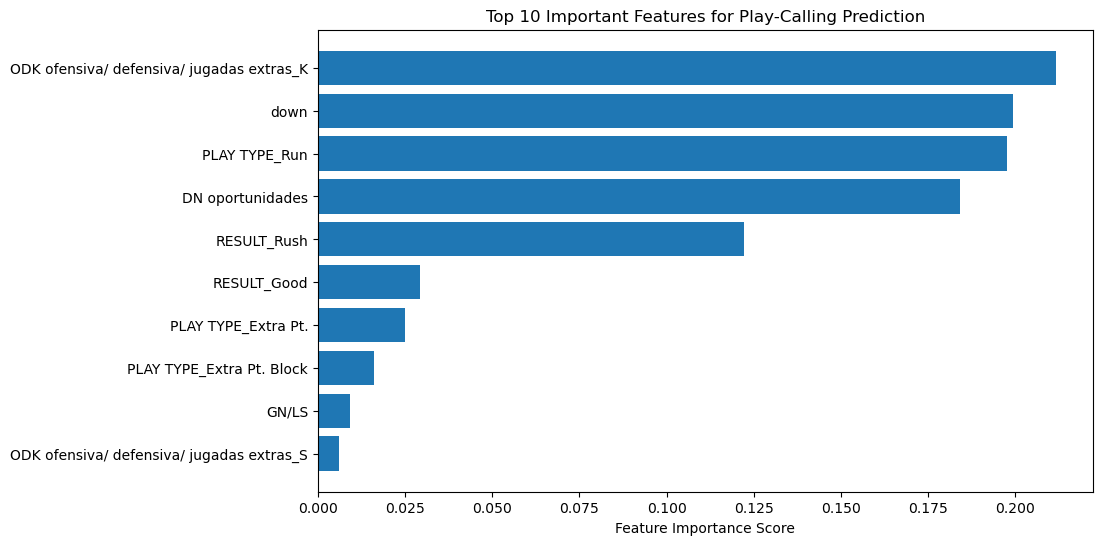

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'best_rf_model' is the trained and tuned Random Forest model
# Extract feature importances
feature_importances = best_rf_model.feature_importances_
feature_names = selected_features  # Replace with actual feature names if different

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance Score')
plt.title('Top 10 Important Features for Play-Calling Prediction')
plt.show()

In [96]:
!pip install shap

   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   --- ----------------------------------- 41.0/456.2 kB 991.0 kB/s eta 0:00:01
   ------ -------------------------------- 71.7/456.2 kB 787.7 kB/s eta 0:00:01
   ------- ------------------------------- 92.2/456.2 kB 871.5 kB/s eta 0:00:01
   ------------------- -------------------- 225.3/456.2 kB 1.3 MB/s eta 0:00:01
   -------------------- ------------------- 235.5/456.2 kB 1.3 MB/s eta 0:00:01
   ----------------------------- ---------- 337.9/456.2 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 1.4 MB/s eta 0:00:00


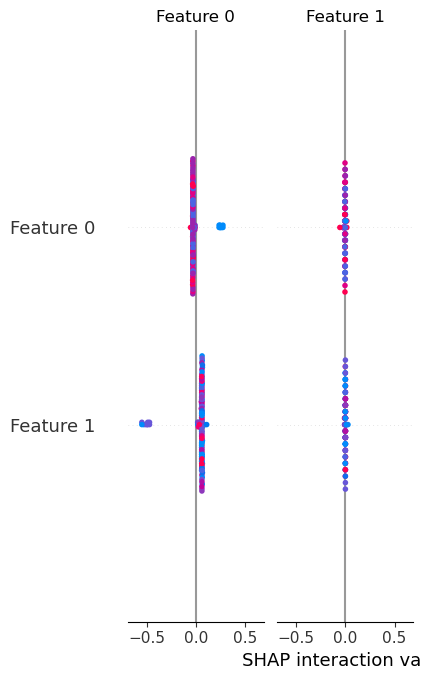

In [112]:
import shap

# Initialize SHAP explainer with the Random Forest model
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values directly with the explainer function
shap_values = explainer(X_test)

# Plot the summary directly on the SHAP values object
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [114]:
import joblib

# Save the trained model
joblib.dump(best_rf_model, 'best_rf_playcall_model.joblib')
print("Model saved as 'best_rf_playcall_model.joblib'")

Model saved as 'best_rf_playcall_model.joblib'


In [116]:
# Load the saved model
loaded_model = joblib.load('best_rf_playcall_model.joblib')
# Make predictions with the loaded model
predictions = loaded_model.predict(X_test)

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_on_new_data(model, X_new, y_new):
    preds = model.predict(X_new)
    accuracy = accuracy_score(y_new, preds)
    precision = precision_score(y_new, preds)
    recall = recall_score(y_new, preds)
    f1 = f1_score(y_new, preds)

    print("Model Evaluation on New Data:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Return results for logging or further analysis
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}



# Resumen

## Importancia de Características y Análisis SHAP
La **importancia de características** y el análisis **SHAP** ayudan a identificar los factores clave que influyen en las decisiones de llamadas de jugadas, haciendo que el modelo sea más interpretable.

## Despliegue
El modelo se guarda utilizando `joblib`, lo que permite que se vuelva a cargar para su uso en producción.

## Monitoreo
La evaluación regular con nuevos datos asegura un rendimiento consistente, rastreando métricas clave para detectar cambios en el tiempo.

Este flujo de trabajo asegura que el modelo sea interpretable y esté listo para su despliegue, con un monitoreo en marcha para mantener su fiabilidad.


In [121]:
#pip install Flask

Note: you may need to restart the kernel to use updated packages.


In [17]:
# Load the processed data used for training
training_data = pd.read_csv('playdata_processed.csv')
print("Training data columns:", training_data.columns)
print("Number of features in training data:", len(training_data.columns) - 1)  # Exclude target column

Training data columns: Index(['PLAY #', 'HF 1ª o 2ª parte ', 'SERIES oportunidades',
       'DN oportunidades', 'DISTANCIA', 'YARD LN', 'RESULT', 'PI', 'PC',
       'GN/LS', 'PLAY DIR', 'PASS ZONE', 'COVERAGE', 'BLZ_Jersey', 'BLZ_Name',
       'RIVAL_CAN', 'RIVAL_FRA', 'RIVAL_ITA', 'RIVAL_NZL', 'RIVAL_SUI',
       'RIVAL_SUIZA', 'RIVAL_USA', 'ODK ofensiva/ defensiva/ jugadas extras_K',
       'ODK ofensiva/ defensiva/ jugadas extras_O',
       'ODK ofensiva/ defensiva/ jugadas extras_S', 'OFF FORM_ARROW',
       'OFF FORM_BUNCH', 'OFF FORM_DOBLE TIGHT', 'OFF FORM_DOBLES',
       'OFF FORM_I', 'OFF FORM_ISO', 'OFF FORM_SLOT', 'OFF FORM_SLOT TIGHT',
       'OFF FORM_SPREAD BUNCH', 'OFF FORM_TIGHT', 'OFF FORM_TRIPS',
       'OFF FORM_TRIPS TIGHT', 'OFF FORM_USA', 'OFF STR_L', 'OFF STR_R',
       'PLAY TYPE_2 Pt. Defend', 'PLAY TYPE_Extra Pt.',
       'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Pass', 'PLAY TYPE_Run',
       'quarter', 'down', 'field_zone_Red Zone',
       'play_result_categor

In [21]:
import pandas as pd

# Load the dataset
training_data = pd.read_csv('playdata_processed.csv')

# Display the column names to identify the correct target column
print("Columns in training data:", training_data.columns)

Columns in training data: Index(['PLAY #', 'HF 1ª o 2ª parte ', 'SERIES oportunidades',
       'DN oportunidades', 'DISTANCIA', 'YARD LN', 'RESULT', 'PI', 'PC',
       'GN/LS', 'PLAY DIR', 'PASS ZONE', 'COVERAGE', 'BLZ_Jersey', 'BLZ_Name',
       'RIVAL_CAN', 'RIVAL_FRA', 'RIVAL_ITA', 'RIVAL_NZL', 'RIVAL_SUI',
       'RIVAL_SUIZA', 'RIVAL_USA', 'ODK ofensiva/ defensiva/ jugadas extras_K',
       'ODK ofensiva/ defensiva/ jugadas extras_O',
       'ODK ofensiva/ defensiva/ jugadas extras_S', 'OFF FORM_ARROW',
       'OFF FORM_BUNCH', 'OFF FORM_DOBLE TIGHT', 'OFF FORM_DOBLES',
       'OFF FORM_I', 'OFF FORM_ISO', 'OFF FORM_SLOT', 'OFF FORM_SLOT TIGHT',
       'OFF FORM_SPREAD BUNCH', 'OFF FORM_TIGHT', 'OFF FORM_TRIPS',
       'OFF FORM_TRIPS TIGHT', 'OFF FORM_USA', 'OFF STR_L', 'OFF STR_R',
       'PLAY TYPE_2 Pt. Defend', 'PLAY TYPE_Extra Pt.',
       'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Pass', 'PLAY TYPE_Run',
       'quarter', 'down', 'field_zone_Red Zone',
       'play_result_cate

In [27]:
import pandas as pd

# Load the processed training data
training_data = pd.read_csv('playdata_processed.csv')

# Define the target column based on available columns
target_column = 'PLAY TYPE_Pass'  # Adjust this if you intended a different play type

# Drop the target column and get the list of feature columns
training_features = training_data.drop(columns=[target_column]).columns

# Print to confirm the expected features
print("Expected features for the model:", list(training_features))
print("Number of features:", len(training_features))

Expected features for the model: ['PLAY #', 'HF 1ª o 2ª parte ', 'SERIES oportunidades', 'DN oportunidades', 'DISTANCIA', 'YARD LN', 'RESULT', 'PI', 'PC', 'GN/LS', 'PLAY DIR', 'PASS ZONE', 'COVERAGE', 'BLZ_Jersey', 'BLZ_Name', 'RIVAL_CAN', 'RIVAL_FRA', 'RIVAL_ITA', 'RIVAL_NZL', 'RIVAL_SUI', 'RIVAL_SUIZA', 'RIVAL_USA', 'ODK ofensiva/ defensiva/ jugadas extras_K', 'ODK ofensiva/ defensiva/ jugadas extras_O', 'ODK ofensiva/ defensiva/ jugadas extras_S', 'OFF FORM_ARROW', 'OFF FORM_BUNCH', 'OFF FORM_DOBLE TIGHT', 'OFF FORM_DOBLES', 'OFF FORM_I', 'OFF FORM_ISO', 'OFF FORM_SLOT', 'OFF FORM_SLOT TIGHT', 'OFF FORM_SPREAD BUNCH', 'OFF FORM_TIGHT', 'OFF FORM_TRIPS', 'OFF FORM_TRIPS TIGHT', 'OFF FORM_USA', 'OFF STR_L', 'OFF STR_R', 'PLAY TYPE_2 Pt. Defend', 'PLAY TYPE_Extra Pt.', 'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Run', 'quarter', 'down', 'field_zone_Red Zone', 'play_result_category_Turnover']
Number of features: 48


In [35]:
# Define sample input data with exact columns as in training data
sample_data = {
    'PLAY #': [1],
    'HF 1ª o 2ª parte': [1],
    'SERIES oportunidades': [3],
    'DN oportunidades': [2],
    'DISTANCIA': [5],
    'YARD LN': [35],
    'PI': [0],
    'PC': [0],
    'GN/LS': [3],
    'PASS ZONE': [1],
    # Add all remaining features exactly as they appear in training data
}

sample_df = pd.DataFrame(sample_data)

In [41]:
import joblib

# Load the trained model
model = joblib.load('best_rf_playcall_model.joblib')

# Print number of features model was trained on
print("Number of features model expects:", model.n_features_in_)

Number of features model expects: 10


### EJEMPLO ###

In [45]:
import pandas as pd
import joblib

# Load the model
model = joblib.load('best_rf_playcall_model.joblib')

# Define the 10 features with actual values
sample_data = pd.DataFrame({
    'PLAY #': [1],
    'quarter': [2],
    'down': [2],
    'DISTANCIA': [5],
    'YARD LN': [35],
    'SERIES oportunidades': [3],
    'DN oportunidades': [2],
    'PI': [0],
    'PC': [0],
    'GN/LS': [3]
    # Ensure these are the exact 10 features the model expects
})

# Make prediction
prediction = model.predict(sample_data.to_numpy())

# Interpret the prediction
print("Predicted play type:", "Run" if prediction[0] == 1 else "Pass")

Predicted play type: Pass


# Explicación del Código

Este código define una muestra de datos (`sample_data`) con 10 características específicas para realizar una predicción sobre el tipo de jugada (por ejemplo, "Correr" o "Pase") usando un modelo de Machine Learning previamente entrenado.

## Desglose del Código

1. **Definir las Características**: 
   - `sample_data` se crea como un `DataFrame` de pandas con los valores específicos de 10 características seleccionadas.
   - Las características incluyen información como el número de la jugada (`PLAY #`), el cuarto (`quarter`), el intento actual (`down`), la distancia hasta la línea de anotación (`DISTANCIA`), la línea de yardas (`YARD LN`), entre otras.
   - Asegúrate de que estas características coincidan exactamente con las que el modelo fue entrenado, para evitar errores en la predicción.

2. **Realizar la Predicción**:
   - `model.predict(sample_data.to_numpy())` convierte el `DataFrame` en un array de NumPy y pasa los datos al modelo para predecir el tipo de jugada.
   - La predicción resultante se almacena en `prediction`.

3. **Interpretar el Resultado**:
   - La línea `print("Predicted play type:", "Run" if prediction[0] == 1 else "Pass")` interpreta la predicción.
   - Si el valor de `prediction[0]` es `1`, se muestra que el modelo recomienda una jugada de "Correr". Si es `0`, el modelo sugiere una jugada de "Pase".

## Resumen
Este código utiliza datos de una jugada específica para predecir el tipo de jugada recomendada usando un modelo de clasificación. Asegúrate de que los valores de entrada (características) coincidan con los que el modelo espera para obtener resultados precisos.

# 2)PREDICCIÓN DE ZONA DEL PASE #

In [5]:
import pandas as pd

# Load the data using the correct file path
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')  # Update this path
print("Columns in the dataset:", data.columns)

Columns in the dataset: Index(['PLAY #', 'HF 1ª o 2ª parte ', 'SERIES oportunidades',
       'DN oportunidades', 'DISTANCIA', 'YARD LN', 'RESULT', 'PI', 'PC',
       'GN/LS', 'PLAY DIR', 'PASS ZONE', 'COVERAGE', 'BLZ_Jersey', 'BLZ_Name',
       'RIVAL_CAN', 'RIVAL_FRA', 'RIVAL_ITA', 'RIVAL_NZL', 'RIVAL_SUI',
       'RIVAL_SUIZA', 'RIVAL_USA', 'ODK ofensiva/ defensiva/ jugadas extras_K',
       'ODK ofensiva/ defensiva/ jugadas extras_O',
       'ODK ofensiva/ defensiva/ jugadas extras_S', 'OFF FORM_ARROW',
       'OFF FORM_BUNCH', 'OFF FORM_DOBLE TIGHT', 'OFF FORM_DOBLES',
       'OFF FORM_I', 'OFF FORM_ISO', 'OFF FORM_SLOT', 'OFF FORM_SLOT TIGHT',
       'OFF FORM_SPREAD BUNCH', 'OFF FORM_TIGHT', 'OFF FORM_TRIPS',
       'OFF FORM_TRIPS TIGHT', 'OFF FORM_USA', 'OFF STR_L', 'OFF STR_R',
       'PLAY TYPE_2 Pt. Defend', 'PLAY TYPE_Extra Pt.',
       'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Pass', 'PLAY TYPE_Run',
       'quarter', 'down', 'field_zone_Red Zone',
       'play_result_catego

In [11]:
# Check for missing values in the target column
print("Missing values in target column (PASS ZONE):", data['PASS ZONE'].isna().sum())

# Option 1: Drop rows with missing target values
data = data.dropna(subset=['PASS ZONE'])

# After handling missing values, redefine X and y
X = data[features]
y = data['PASS ZONE']

# Convert categorical features in X to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Proceed with model training as before
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model performance
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Missing values in target column (PASS ZONE): 51
Accuracy: 0.4
              precision    recall  f1-score   support

         1.0       0.43      0.41      0.42        22
         2.0       0.06      0.07      0.06        15
         3.0       0.62      0.61      0.62        41
         4.0       0.33      0.67      0.44         3
         5.0       0.00      0.00      0.00         4
         6.0       0.12      0.20      0.15         5
         7.0       0.38      0.50      0.43         6
         8.0       0.00      0.00      0.00         6
         9.0       0.27      0.38      0.32         8

    accuracy                           0.40       110
   macro avg       0.25      0.31      0.27       110
weighted avg       0.38      0.40      0.39       110



C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load and prepare the data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')
data = data.dropna(subset=['PASS ZONE'])  # Remove rows with missing target values

# Adjust target labels to start from 0
data['PASS ZONE'] = data['PASS ZONE'] - 1

# Define features and target
features = [
    'quarter', 'down', 'DISTANCIA', 'YARD LN', 
    'SERIES oportunidades', 'DN oportunidades', 'PI', 'PC', 'GN/LS', 'PLAY DIR'
]
X = pd.get_dummies(data[features], drop_first=True)
y = data['PASS ZONE']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use XGBoost with class weights (if imbalance exists)
model = XGBClassifier(scale_pos_weight=len(y_train) / y_train.value_counts(), random_state=42)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\lalde\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.39090909090909093
              precision    recall  f1-score   support

         0.0       0.50      0.41      0.45        22
         1.0       0.13      0.20      0.16        15
         2.0       0.64      0.56      0.60        41
         3.0       0.29      0.67      0.40         3
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         5
         6.0       0.43      0.50      0.46         6
         7.0       0.00      0.00      0.00         6
         8.0       0.25      0.38      0.30         8

    accuracy                           0.39       110
   macro avg       0.25      0.30      0.26       110
weighted avg       0.41      0.39      0.39       110



C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load and prepare the data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')
data = data.dropna(subset=['PASS ZONE'])  # Remove rows with missing target values

# Adjust target labels to start from 0
data['PASS ZONE'] = data['PASS ZONE'] - 1

# Define features and target
features = [
    'quarter', 'down', 'DISTANCIA', 'YARD LN', 
    'SERIES oportunidades', 'DN oportunidades', 'PI', 'PC', 'GN/LS', 'PLAY DIR'
]
X = pd.get_dummies(data[features], drop_first=True)
y = data['PASS ZONE']

# Handle missing values in X by imputing with median
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance classes in the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Use XGBoost for training
model = XGBClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

# Evaluate performance
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4090909090909091
              precision    recall  f1-score   support

         0.0       0.58      0.50      0.54        22
         1.0       0.20      0.27      0.23        15
         2.0       0.64      0.51      0.57        41
         3.0       0.38      1.00      0.55         3
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         5
         6.0       0.57      0.67      0.62         6
         7.0       0.00      0.00      0.00         6
         8.0       0.15      0.25      0.19         8

    accuracy                           0.41       110
   macro avg       0.28      0.36      0.30       110
weighted avg       0.43      0.41      0.41       110



In [21]:
pip install catboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB 393.8 kB/s eta 0:04:19
   ---------------------------------------- 0.1/101.7 MB 726.2 kB/s eta 0:02:20
   ---------------------------------------- 0.2/101.7 MB 1.3 MB/s eta 0:01:18
   ---------------------------------------- 0.4/101.7 MB 1.8 MB/s eta 0:00:56
   ---------------------------------------- 0.8/101.7 MB 3.2 MB/s eta 0:00:32
   ---------------------------------------- 1.1/101.7 MB 3.5 MB/s eta 0:00:29
    --------------------------------------- 2.1/101.7 MB 6.1 MB/s eta 0:00:17
   - -------------------------------------- 3.0/101.7 MB 8.1 MB/s eta 0:00:13
   - -------------------------------------- 5.0/101.7 MB 11.9 MB/s eta 0:00:09
   -- ------------------------------------- 6.1/101.7 MB 13.0 MB/s eta 0:00:08
 

In [23]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import pandas as pd

# Load and prepare the data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')
data = data.dropna(subset=['PASS ZONE'])  # Remove rows with missing target values

# Adjust target labels to start from 0
data['PASS ZONE'] = data['PASS ZONE'] - 1

# Define features and target
features = [
    'quarter', 'down', 'DISTANCIA', 'YARD LN', 
    'SERIES oportunidades', 'DN oportunidades', 'PI', 'PC', 'GN/LS', 'PLAY DIR'
]
X = pd.get_dummies(data[features], drop_first=True)
y = data['PASS ZONE']

# Impute missing values
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and train the CatBoost model with class weights for imbalanced data
model = CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, random_seed=42, verbose=0)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.44545454545454544
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50        22
         1.0       0.12      0.13      0.12        15
         2.0       0.64      0.71      0.67        41
         3.0       0.50      1.00      0.67         3
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         5
         6.0       0.50      0.50      0.50         6
         7.0       0.00      0.00      0.00         6
         8.0       0.08      0.12      0.10         8

    accuracy                           0.45       110
   macro avg       0.26      0.33      0.29       110
weighted avg       0.40      0.45      0.42       110



C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load and prepare the data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')
data = data.dropna(subset=['PASS ZONE'])  # Remove rows with missing target values
data['PASS ZONE'] = data['PASS ZONE'] - 1

# Define features and target
features = [
    'quarter', 'down', 'DISTANCIA', 'YARD LN', 
    'SERIES oportunidades', 'DN oportunidades', 'PI', 'PC', 'GN/LS', 'PLAY DIR'
]
X = pd.get_dummies(data[features], drop_first=True)
y = data['PASS ZONE']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base models and stacking classifier
base_models = [
    ('catboost', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, random_seed=42, verbose=0)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

stacked_model = StackingClassifier(estimators=base_models, final_estimator=RandomForestClassifier(random_state=42))

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Evaluate performance
y_pred = stacked_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\lalde\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lalde\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lalde\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:08:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lalde\anaconda3\Lib\site-packages\

Accuracy: 0.4909090909090909
              precision    recall  f1-score   support

         0.0       0.52      0.68      0.59        22
         1.0       0.17      0.13      0.15        15
         2.0       0.63      0.80      0.71        41
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         4
         5.0       0.20      0.20      0.20         5
         6.0       0.33      0.17      0.22         6
         7.0       0.00      0.00      0.00         6
         8.0       0.29      0.25      0.27         8

    accuracy                           0.49       110
   macro avg       0.24      0.25      0.24       110
weighted avg       0.41      0.49      0.44       110



C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Load data and target encoding adjustments
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')
data = data.dropna(subset=['PASS ZONE'])  # Remove rows with missing target values
data['PASS ZONE'] = data['PASS ZONE'] - 1

# Define features and target
features = [
    'quarter', 'down', 'DISTANCIA', 'YARD LN', 
    'SERIES oportunidades', 'DN oportunidades', 'PI', 'PC', 'GN/LS', 'PLAY DIR'
]
X = pd.get_dummies(data[features], drop_first=True)
y = data['PASS ZONE']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply SMOTE with auto strategy or adjusted counts
# Option 1: Auto
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Option 2: Adjust individual counts (ensure counts are >= current values)
# smote = SMOTE(sampling_strategy={3.0: 25, 4.0: 25, 5.0: 25, 7.0: 25}, random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# Define and train the stacking model
base_models = [
    ('catboost', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, random_seed=42, verbose=0)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]
stacked_model = StackingClassifier(estimators=base_models, final_estimator=RandomForestClassifier(random_state=42))

stacked_model.fit(X_train_res, y_train_res)

# Evaluate model performance
y_pred = stacked_model.predict(X_test_imputed)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\lalde\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lalde\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lalde\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\lalde\anaconda3\Lib\site-packages\

Accuracy: 0.41818181818181815
              precision    recall  f1-score   support

         0.0       0.50      0.45      0.48        22
         1.0       0.09      0.07      0.08        15
         2.0       0.66      0.61      0.63        41
         3.0       0.43      1.00      0.60         3
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         5
         6.0       0.57      0.67      0.62         6
         7.0       0.00      0.00      0.00         6
         8.0       0.18      0.38      0.24         8

    accuracy                           0.42       110
   macro avg       0.27      0.35      0.29       110
weighted avg       0.41      0.42      0.41       110



In [63]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import SMOTEENN
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer

# Step 1: Load and Preprocess Data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')

# Define target column and features
target_column = 'PASS ZONE'
data = data.dropna(subset=[target_column])  # Drop rows where target is NaN
X = data.drop(columns=[target_column])
y = data[target_column]

# Drop columns with all NaN values
X = X.drop(columns=['RESULT', 'PLAY DIR', 'COVERAGE', 'BLZ_Name'], errors='ignore')

# Convert columns to numeric where possible and handle remaining NaN values
X = X.apply(pd.to_numeric, errors='coerce')

# Impute remaining NaN values with column means
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Step 2: Check and Define class weights only if required (Optional)
# Since we are using SMOTEENN, we skip applying class weights for now.

# Step 3: Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Apply SMOTE-ENN for targeted oversampling and cleaning on the training data only
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

# Verify the unique classes in the resampled training data
print("Unique classes in resampled training data:", np.unique(y_train_res))

# Step 5: Model Training - Stacking Classifier with base models
base_models = [
    ('catboost', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, random_seed=42, verbose=0)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  # No class_weight in base models
]

# Configure final estimator without class_weight
final_estimator = RandomForestClassifier(n_estimators=200, random_state=42)

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=final_estimator,
    n_jobs=-1
)

# Train the stacking model on resampled data
stacking_model.fit(X_train_res, y_train_res)

# Step 6: Evaluate model performance on the test set
y_pred = stacking_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Step 7: Hyperparameter tuning for the final estimator in the stacking model
param_grid = {
    'final_estimator__n_estimators': [100, 200],
    'final_estimator__max_depth': [6, 8, 10]
}

grid_search = GridSearchCV(stacking_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Display best parameters and final accuracy after tuning
print("Best Parameters from Grid Search:", grid_search.best_params_)
y_pred_tuned = grid_search.best_estimator_.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
report_tuned = classification_report(y_test, y_pred_tuned)

print("Tuned Accuracy:", accuracy_tuned)
print("Tuned Classification Report:\n", report_tuned)

Unique classes in resampled training data: [1. 2. 3. 4. 5. 6. 7. 8. 9.]


C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packag

Accuracy: 0.10909090909090909
Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        24
         2.0       0.15      0.16      0.15        19
         3.0       0.00      0.00      0.00        30
         4.0       0.09      0.60      0.16         5
         5.0       0.07      0.25      0.11         4
         6.0       0.08      0.12      0.10         8
         7.0       0.12      0.14      0.13         7
         8.0       0.00      0.00      0.00         3
         9.0       0.15      0.30      0.20        10

    accuracy                           0.11       110
   macro avg       0.07      0.18      0.09       110
weighted avg       0.06      0.11      0.07       110



C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\lalde\anaconda3\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lalde\anaconda3\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\utils\parallel.py", line 129, in __call__
  

Best Parameters from Grid Search: {'final_estimator__max_depth': 6, 'final_estimator__n_estimators': 100}
Tuned Accuracy: 0.11818181818181818
Tuned Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        24
         2.0       0.15      0.21      0.17        19
         3.0       0.00      0.00      0.00        30
         4.0       0.10      0.60      0.18         5
         5.0       0.07      0.25      0.11         4
         6.0       0.08      0.12      0.10         8
         7.0       0.12      0.14      0.13         7
         8.0       0.00      0.00      0.00         3
         9.0       0.20      0.30      0.24        10

    accuracy                           0.12       110
   macro avg       0.08      0.18      0.10       110
weighted avg       0.06      0.12      0.08       110



C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lalde\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### SWITCHING FRO 

In [64]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')

# Define target column and features
target_column = 'PASS ZONE'
data = data.dropna(subset=[target_column])  # Drop rows where target is NaN
X = data.drop(columns=[target_column])
y = data[target_column]

# Drop columns with all NaN values
X = X.drop(columns=['RESULT', 'PLAY DIR', 'COVERAGE', 'BLZ_Name'], errors='ignore')

# Convert columns to numeric and handle remaining NaN values
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.mean(), inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Convert labels to categorical format
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train - 1, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test - 1, num_classes)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) + 1  # Convert back to original labels
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Neural Network Accuracy:", accuracy)
print("Neural Network Classification Report:\n", report)

C:\Users\lalde\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.1202 - loss: 2.1759 - val_accuracy: 0.1818 - val_loss: 2.1511
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1468 - loss: 2.1548 - val_accuracy: 0.1818 - val_loss: 2.1734
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1060 - loss: 2.1449 - val_accuracy: 0.1727 - val_loss: 2.1663
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1433 - loss: 2.2079 - val_accuracy: 0.1818 - val_loss: 2.1588
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1549 - loss: 2.1703 - val_accuracy: 0.1636 - val_loss: 2.1585
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1562 - loss: 2.1487 - val_accuracy: 0.1818 - val_loss: 2.1558
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1821 - loss: 2.0052 - val_accuracy: 0.1727 - val_loss: 2.1461
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1728 - loss: 2.1840 - val_accuracy: 0.1636 - 

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

# Load and preprocess data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')

# Define target column and features
target_column = 'PASS ZONE'
data = data.dropna(subset=[target_column])  # Drop rows where target is NaN
X = data.drop(columns=[target_column])
y = data[target_column]

# Drop columns with all NaN values
X = X.drop(columns=['RESULT', 'PLAY DIR', 'COVERAGE', 'BLZ_Name'], errors='ignore')

# Convert columns to numeric and handle remaining NaN values
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.mean(), inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

# Convert labels to categorical format
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train - 1, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test - 1, num_classes)

# Define the neural network model with Batch Normalization
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model with Adam optimizer and a reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) + 1  # Convert back to original labels
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Improved Neural Network Accuracy:", accuracy)
print("Improved Neural Network Classification Report:\n", report)

Epoch 1/200


C:\Users\lalde\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.1172 - loss: 3.2518 - val_accuracy: 0.1861 - val_loss: 2.1508
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1545 - loss: 2.7857 - val_accuracy: 0.2847 - val_loss: 2.0844
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2357 - loss: 2.5074 - val_accuracy: 0.3066 - val_loss: 2.0264
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2328 - loss: 2.4385 - val_accuracy: 0.3212 - val_loss: 1.9699
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2577 - loss: 2.3724 - val_accuracy: 0.3394 - val_loss: 1.9185
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2759 - loss: 2.2480 - val_accuracy: 0.3540 - val_loss: 1.8632
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3017 - loss: 2.1282 - val_accuracy: 0.3869 - val_loss: 1.8093
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2885 - loss: 2.1764 - val_accuracy: 0.4015 - val_loss: 1.

In [75]:
model.save('passing_zone_prediction_model.h5')

In [77]:
pip install tensorflow pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [81]:
# Save the trained model to the specified path
model.save('C:/Users/lalde/Downloads/passing_zone_predictor_model.h5')

In [87]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load the pre-trained neural network model
model = tf.keras.models.load_model('C:/Users/lalde/Downloads/passing_zone_predictor_model.h5')

# Load and preprocess the play data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')

# Define the essential features based on the model training
essential_features = ['SERIES oportunidades', 'DN oportunidades', 'DISTANCIA', 'YARD LN']
new_data_filtered = data[essential_features].copy()

# Ensure new_data has the required number of columns with the exact names
required_columns = model.input_shape[1]  # This should be 44 based on the model's expected input
all_columns = new_data_filtered.columns.tolist() + [f"missing_feature_{i}" for i in range(len(new_data_filtered.columns), required_columns)]
new_data_filtered = pd.DataFrame(new_data_filtered, columns=all_columns).fillna(0)

# Load the scaler (if saved previously, load it; otherwise, fit it here with training data, if available)
# Note: scaler should be fit on training data and saved if not done already

scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_data_filtered)  # Ensure the scaler is trained with the right feature names

# Make predictions
predictions = model.predict(X_scaled)
predicted_pass_zones = np.argmax(predictions, axis=1) + 1  # Adjust indexing if necessary

# Display predictions for the first few rows
print("Predicted Passing Zones for Sample Plays:")
for i, zone in enumerate(predicted_pass_zones[:10]):
    print(f"Play {i+1}: Passing Zone {zone}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Predicted Passing Zones for Sample Plays:
Play 1: Passing Zone 5
Play 2: Passing Zone 5
Play 3: Passing Zone 5
Play 4: Passing Zone 5
Play 5: Passing Zone 5
Play 6: Passing Zone 5
Play 7: Passing Zone 5
Play 8: Passing Zone 5
Play 9: Passing Zone 5
Play 10: Passing Zone 5


In [89]:
# Show the probability predictions for the first few samples
for i, prob in enumerate(predictions[:10]):
    print(f"Play {i+1}: Probability distribution across zones: {prob}")

Play 1: Probability distribution across zones: [0.09012244 0.18101583 0.14471224 0.05009711 0.19988413 0.092541
 0.0831873  0.03590608 0.12253387]
Play 2: Probability distribution across zones: [0.08521507 0.17534886 0.1565646  0.0491723  0.20191963 0.09671745
 0.09762833 0.03195246 0.10548135]
Play 3: Probability distribution across zones: [0.0768121  0.17132178 0.17405418 0.05138087 0.19930354 0.0851033
 0.12235995 0.03104514 0.08861919]
Play 4: Probability distribution across zones: [0.07781535 0.17183177 0.15247962 0.04859711 0.20775606 0.0994585
 0.09957658 0.03484761 0.10763741]
Play 5: Probability distribution across zones: [0.08360981 0.17254962 0.15353861 0.04839047 0.2052247  0.09922567
 0.09870408 0.03394902 0.10480802]
Play 6: Probability distribution across zones: [0.08352961 0.16225712 0.16350546 0.05304635 0.1952983  0.09485321
 0.1147516  0.03405986 0.09869847]
Play 7: Probability distribution across zones: [0.07489727 0.17015825 0.15338004 0.04650791 0.20509253 0.09928

In [91]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Load the data
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')
target_column = 'PASS ZONE'
data = data.dropna(subset=[target_column])
X = data.drop(columns=[target_column])
y = data[target_column]

# Drop columns with all NaN values
X = X.drop(columns=['RESULT', 'PLAY DIR', 'COVERAGE', 'BLZ_Name'], errors='ignore')
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.mean(), inplace=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

In [93]:
# Calculate class weights dynamically based on the rebalanced data
classes = np.unique(y_res)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_res)
class_weight_dict = dict(zip(classes, class_weights))

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the neural network model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_res.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])

# Compile the model with a reduced learning rate and class weights
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\lalde\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [121]:
# Compile the model using sparse categorical cross-entropy, compatible with integer labels
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Confirm labels are integer arrays starting from 0
print("Unique labels in y_train after adjustment:", np.unique(y_train))
print("Unique labels in y_test after adjustment:", np.unique(y_test))

# Display shapes to ensure they're compatible with model expectations
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Train the model with the corrected class weights and early stopping/reduce_lr callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Unique labels in y_train after adjustment: [0 1 2 3 4 5 6 7 8]
Unique labels in y_test after adjustment: [0. 1. 2. 3. 4. 5. 6. 7. 8.]
Shape of y_train: (1094,)
Shape of y_test: (274,)
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.1505 - loss: 3.2467 - val_accuracy: 0.2628 - val_loss: 2.5316 - learning_rate: 5.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1993 - loss: 2.9587 - val_accuracy: 0.3394 - val_loss: 2.4625 - learning_rate: 5.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2726 - loss: 2.7515 - val_accuracy: 0.3832 - val_loss: 2.3935 - learning_rate: 5.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2775 - loss: 2.6295 - val_accuracy: 0.4270 - val_loss: 2.3302 - learning_rate: 5.0000e-04
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3002 - loss: 2.6475 - val_accuracy: 0.4234 - val_loss: 2.2677 - learning_rate: 5.0000e-04
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0

In [123]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 1.0691 
Test Loss: 1.0373992919921875
Test Accuracy: 0.7883211970329285


### EJEMPLO EN UNA JUGADA ###

In [138]:
import pandas as pd

# Load the dataset to verify actual feature columns
data = pd.read_csv('C:/Users/lalde/Downloads/playdata_processed.csv')
print("Actual Columns in Data:", data.columns.tolist())
print("Total Columns:", len(data.columns))

# Our feature_columns list:
feature_columns = [
    'SERIES oportunidades', 'DN oportunidades', 'DISTANCIA', 'YARD LN', 'PI', 'PC', 'GN/LS', 
    'ODK ofensiva/ defensiva/ jugadas extras_K', 'ODK ofensiva/ defensiva/ jugadas extras_O', 
    'ODK ofensiva/ defensiva/ jugadas extras_S', 'OFF FORM_ARROW', 'OFF FORM_BUNCH', 
    'OFF FORM_DOBLE TIGHT', 'OFF FORM_DOBLES', 'OFF FORM_I', 'OFF FORM_ISO', 'OFF FORM_SLOT', 
    'OFF FORM_SLOT TIGHT', 'OFF FORM_SPREAD BUNCH', 'OFF FORM_TIGHT', 'OFF FORM_TRIPS', 
    'OFF FORM_TRIPS TIGHT', 'OFF FORM_USA', 'OFF STR_L', 'OFF STR_R', 'PLAY TYPE_2 Pt. Defend', 
    'PLAY TYPE_Extra Pt.', 'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Pass', 'PLAY TYPE_Run', 
    'quarter', 'down', 'field_zone_Red Zone', 'play_result_category_Turnover'
]
print("Feature Columns for Model:", feature_columns)
print("Total Feature Columns:", len(feature_columns))

Actual Columns in Data: ['PLAY #', 'HF 1ª o 2ª parte ', 'SERIES oportunidades', 'DN oportunidades', 'DISTANCIA', 'YARD LN', 'RESULT', 'PI', 'PC', 'GN/LS', 'PLAY DIR', 'PASS ZONE', 'COVERAGE', 'BLZ_Jersey', 'BLZ_Name', 'RIVAL_CAN', 'RIVAL_FRA', 'RIVAL_ITA', 'RIVAL_NZL', 'RIVAL_SUI', 'RIVAL_SUIZA', 'RIVAL_USA', 'ODK ofensiva/ defensiva/ jugadas extras_K', 'ODK ofensiva/ defensiva/ jugadas extras_O', 'ODK ofensiva/ defensiva/ jugadas extras_S', 'OFF FORM_ARROW', 'OFF FORM_BUNCH', 'OFF FORM_DOBLE TIGHT', 'OFF FORM_DOBLES', 'OFF FORM_I', 'OFF FORM_ISO', 'OFF FORM_SLOT', 'OFF FORM_SLOT TIGHT', 'OFF FORM_SPREAD BUNCH', 'OFF FORM_TIGHT', 'OFF FORM_TRIPS', 'OFF FORM_TRIPS TIGHT', 'OFF FORM_USA', 'OFF STR_L', 'OFF STR_R', 'PLAY TYPE_2 Pt. Defend', 'PLAY TYPE_Extra Pt.', 'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Pass', 'PLAY TYPE_Run', 'quarter', 'down', 'field_zone_Red Zone', 'play_result_category_Turnover']
Total Columns: 49
Feature Columns for Model: ['SERIES oportunidades', 'DN oportunidades', 

In [169]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.models.load_model('C:/Users/lalde/Downloads/passing_zone_predictor_model.h5')

# Define the 44 feature columns the model expects
feature_columns = [
    'SERIES oportunidades', 'DN oportunidades', 'DISTANCIA', 'YARD LN', 'PI', 'PC', 'GN/LS', 
    'PLAY DIR', 'PASS ZONE', 'COVERAGE', 
    'ODK ofensiva/ defensiva/ jugadas extras_K', 'ODK ofensiva/ defensiva/ jugadas extras_O', 'ODK ofensiva/ defensiva/ jugadas extras_S',
    'OFF FORM_ARROW', 'OFF FORM_BUNCH', 'OFF FORM_DOBLE TIGHT', 'OFF FORM_DOBLES', 'OFF FORM_I', 'OFF FORM_ISO', 
    'OFF FORM_SLOT', 'OFF FORM_SLOT TIGHT', 'OFF FORM_SPREAD BUNCH', 'OFF FORM_TIGHT', 'OFF FORM_TRIPS', 'OFF FORM_TRIPS TIGHT', 
    'OFF FORM_USA', 'OFF STR_L', 'OFF STR_R', 
    'PLAY TYPE_2 Pt. Defend', 'PLAY TYPE_Extra Pt.', 'PLAY TYPE_Extra Pt. Block', 'PLAY TYPE_Pass', 'PLAY TYPE_Run', 
    'quarter', 'down', 'field_zone_Red Zone', 'play_result_category_Turnover',
    'RIVAL_CAN', 'RIVAL_FRA', 'RIVAL_ITA', 'RIVAL_NZL', 'RIVAL_SUI', 'RIVAL_USA', 'Placeholder'  # Placeholder added
]

# Hypothetical values for these features, now with 44 values
new_play_data = pd.DataFrame([[
    1, 1, 10, 20, 1, 1, 5,      # Campos numéricos: métricas básicas de la jugada (serie, down, distancia, línea de yardas, etc.)
    0, 0, 0,                    # Dirección de la jugada, zona de pase, cobertura: indicadores direccionales y de cobertura
    1, 0, 0,                    # Campos binarios ODK: indicadores de acciones ofensivas/defensivas especiales o formaciones
    0, 1, 0, 0, 1, 0, 0,        # Banderas de formaciones ofensivas: formaciones específicas utilizadas (p. ej., slot, trips)
    1, 0, 0, 1, 1,              # Formaciones adicionales y direcciones
    0, 1, 1,                    # Fuerza ofensiva izquierda/derecha
    1, 0, 1, 1, 2,              # Tipo de jugada y otros tipos binarios
    1, 1, 0,                    # Campos de contexto del juego: cuarto, down, posición en el campo (p. ej., zona roja)
    0, 0, 1, 0, 1, 0, 1, 0      # Campos del oponente y marcador de posición
]], columns=feature_columns)

# Standardize the input data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_play_data)

# Make predictions
predicted_pass_zone = model.predict(X_scaled)
predicted_zone_label = np.argmax(predicted_pass_zone, axis=1) + 1  # Adjust index if necessary

print("Predicted Passing Zone:", predicted_zone_label)
print("Probability Distribution Across Zones:", predicted_pass_zone)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predicted Passing Zone: [5]
Probability Distribution Across Zones: [[0.09956098 0.16234791 0.13373208 0.05864197 0.21544608 0.1177903
  0.07702143 0.03179403 0.10366518]]


# Ejemplos de Codificación Categórica

### 1. Dirección de la Jugada (PLAY DIR)
   - `0`: Izquierda
   - `1`: Derecha
   - `2`: Centro

### 2. Zonas de Pase (PASS ZONE)
   Estos valores representan diferentes áreas del campo de juego donde se lanza el pase:
   - `0`: Corta Izquierda
   - `1`: Corta Centro
   - `2`: Corta Derecha
   - `3`: Profunda Izquierda
   - `4`: Profunda Centro
   - `5`: Profunda Derecha

### 3. Cobertura (COVERAGE)
   Esto indica el tipo de cobertura defensiva que enfrenta el equipo ofensivo:
   - `0`: Cobertura de Zona
   - `1`: Cobertura de Hombre a Hombre
   - `2`: Cobertura Mixta
   - `3`: Blitz (presión rápida)

### 4. Campos ODK ofensiva/defensiva (ODK ofensiva/ defensiva/ jugadas extras_K, O, S)
   Campos binarios (0 o 1) que indican si una formación ofensiva/defensiva especial está activa:
   - `0`: No activa
   - `1`: Activa

### 5. Formaciones Ofensivas (OFF FORM_ARROW, OFF FORM_BUNCH, etc.)
   Indicadores binarios para formaciones ofensivas específicas:
   - `0`: La formación no está en uso.
   - `1`: La formación está en uso.

   **Ejemplos de Formaciones Comunes:**
   - **OFF FORM_ARROW**: Formación en flecha
   - **OFF FORM_BUNCH**: Formación agrupada
   - **OFF FORM_TRIPS**: Tres receptores en un lado del campo

### 6. Tipo de Jugada (PLAY TYPE)
   Codificación común para diferentes tipos de jugadas:
   - `PLAY TYPE_Pass`: `1` si la jugada es de pase, `0` de lo contrario.
   - `PLAY TYPE_Run`: `1` si la jugada es de carrera, `0` de lo contrario.
   - `PLAY TYPE_Extra Pt.`: `1` si es una jugada de punto extra.

### 7. Indicadores del Rival (RIVAL_CAN, RIVAL_FRA, etc.)
   Valores binarios que representan si el rival es un país específico:
   - `0`: No es el equipo rival.
   - `1`: Es el equipo rival.

   **Ejemplos:**
   - `RIVAL_CAN`: `1` si el rival es Canadá, `0` si no lo es.
   - `RIVAL_FRA`: `1` si el rival es Francia, `0` si no lo es.

## Predicción de la Zona de Pase: Resultados

### Zona de Pase Predicha
- **Zona de Pase:** [5]

### Distribución de Probabilidad entre Zonas
La red neuronal ha proporcionado las probabilidades de cada zona de pase, indicando la confianza en la predicción de cada categoría:

- **Zona 1:** 9.96%
- **Zona 2:** 16.23%
- **Zona 3:** 13.37%
- **Zona 4:** 5.86%
- **Zona 5:** **21.54%** (Zona predicha con mayor probabilidad)
- **Zona 6:** 11.78%
- **Zona 7:** 7.70%
- **Zona 8:** 3.18%
- **Zona 9:** 10.37%

### Interpretación
La zona de pase con la mayor probabilidad es la **Zona 5** con un **21.54%**, siendo esta la zona sugerida por el modelo para el contexto de juego proporcionado.